# Volumetry Analysis
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32, PPMI NC (116) and ADNI NC(308), QC information needed.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [7]:
## read demographic data and freesurfer outputs
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data_dir = Path("/codes/tab_data")
mni_file  = data_dir/'MNI_Des-cere_preped.csv'
adni_ppmi_file = data_dir/'ADNI-PPMI_Des-cere_preped.csv'

mni_df       = pd.read_csv(mni_file , sep=',', header=0, index_col=0);
adni_ppmi_df = pd.read_csv(adni_ppmi_file , sep=',', header=0, index_col=0);

#excluding list
data_df = pd.concat([mni_df, adni_ppmi_df])
drop_col_list = ['Left_WM_hypointensities', 'Right_WM_hypointensities', '5th_Ventricle'];
data_df=data_df.drop(columns=drop_col_list);

In [62]:
# prepare data for this script
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];
analysis_list = ['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent',
                 'Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_White_Matter','Right_Cerebellum_Cortex']+SUIT_l_labels+SUIT_r_labels+SUIT_v_labels+MDTB_labels
curr_df = data_df.loc[:,analysis_list]
curr_df.loc[:,'Cerebellum_White_Matter']=curr_df['Left_Cerebellum_White_Matter']+curr_df['Right_Cerebellum_White_Matter'];
curr_df.loc[:,'Cerebellum_Cortex']=curr_df['Left_Cerebellum_Cortex']+curr_df['Right_Cerebellum_Cortex'];
curr_df.loc[:,'cerebellumVol']=curr_df['Cerebellum_Cortex']+curr_df['Cerebellum_White_Matter']
# calculate the Infra tentorial volumen approximately by eTIV-SupraTentorialVol
curr_df.loc[:,'InfraTentorialVol']=curr_df['eTIV']-curr_df['SupraTentorialVol']
curr_df.loc[:,'male']=[int(x=='M') for x in curr_df['sex']]
df_all=curr_df.copy()
df_all.loc[:,'is_mni'] =[1 if int(x=='ET' or x=='NC') else 0 for x in df_all['group']]
df_all.loc[:,'is_ppmi']=[int(x=='PPMI') for x in df_all['group']]
df_all.loc[:,'is_adni']=[int(x=='ADNI') for x in df_all['group']]
df_all.loc[:,'group']  =[x if x=='ET' else 'NC' for x in df_all['group']]
#print(list(data_df.columns))

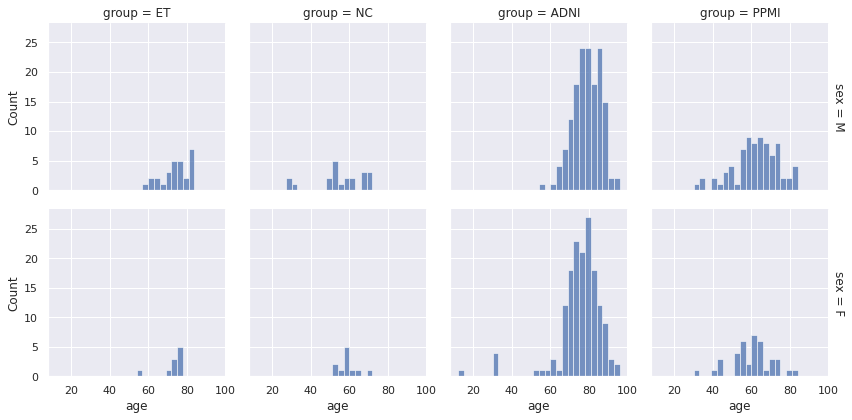

In [9]:
# plot demographic age/sex/group distributions 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    curr_df, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

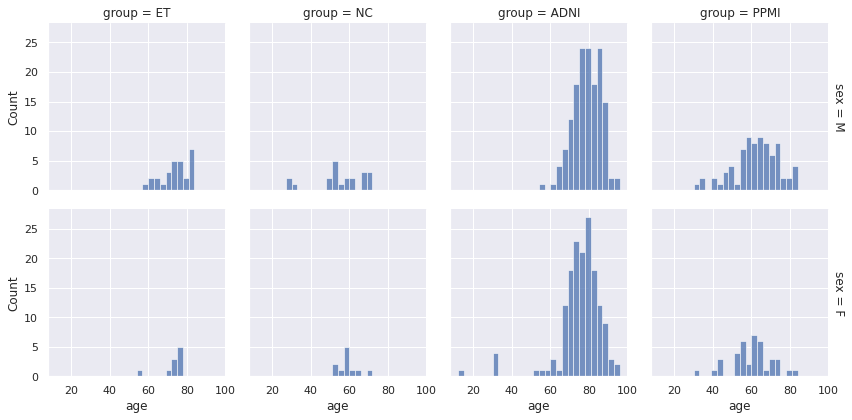

In [10]:
# plot demographic age/sex/group distributions 2*3
sns.set_theme(style="darkgrid")
sns.displot(
    curr_df, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

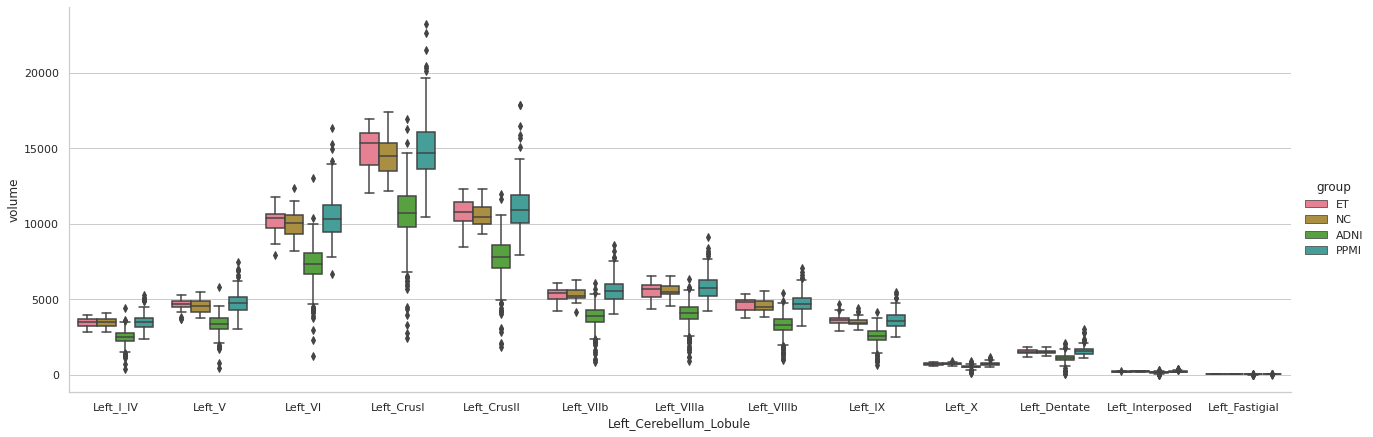

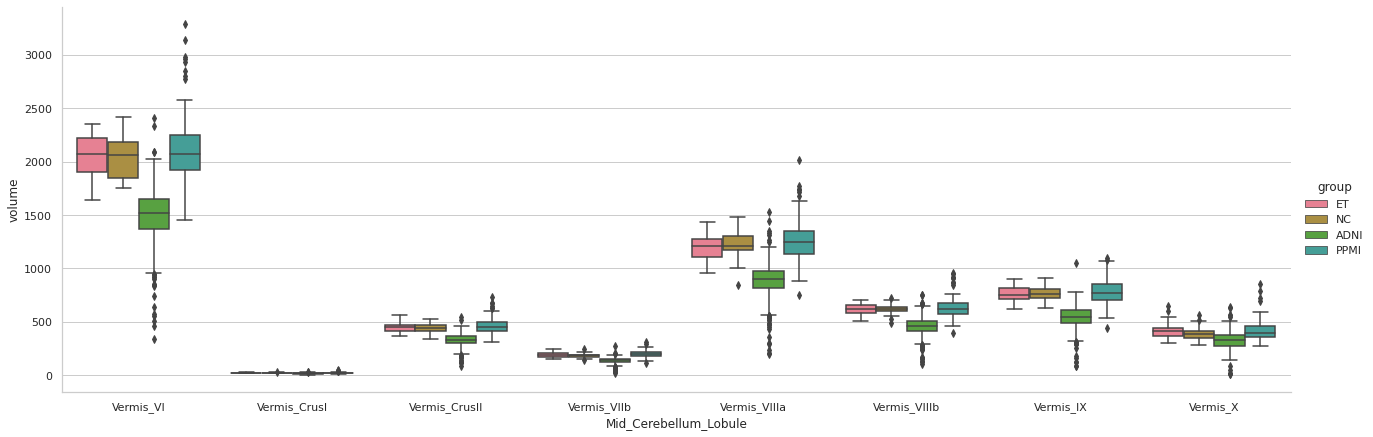

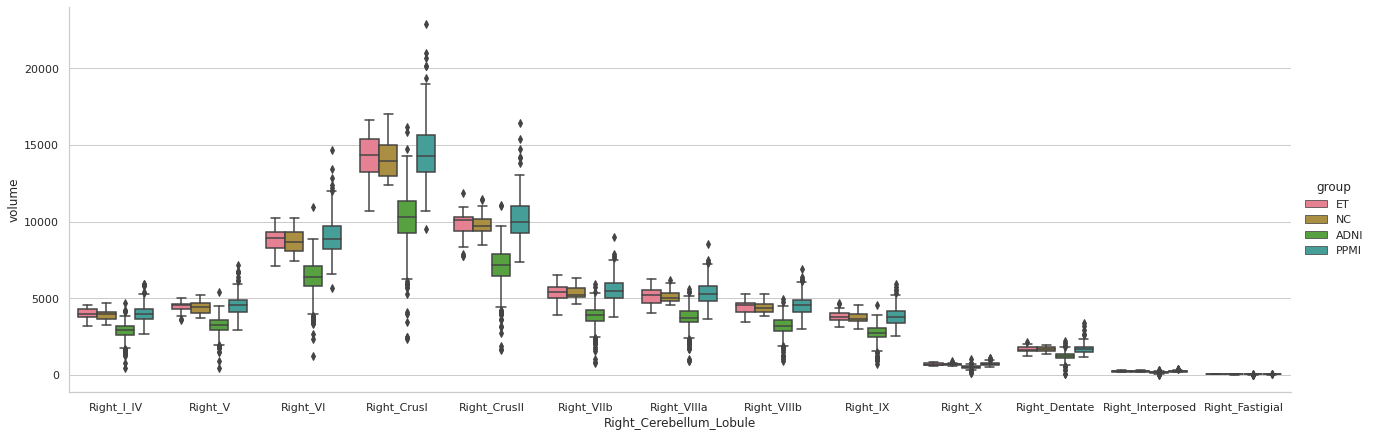

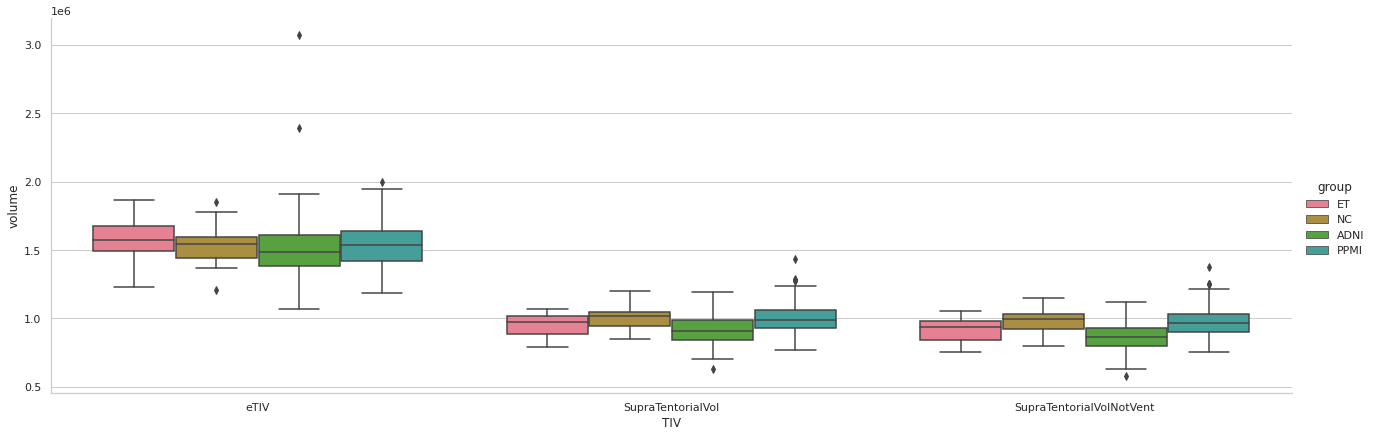

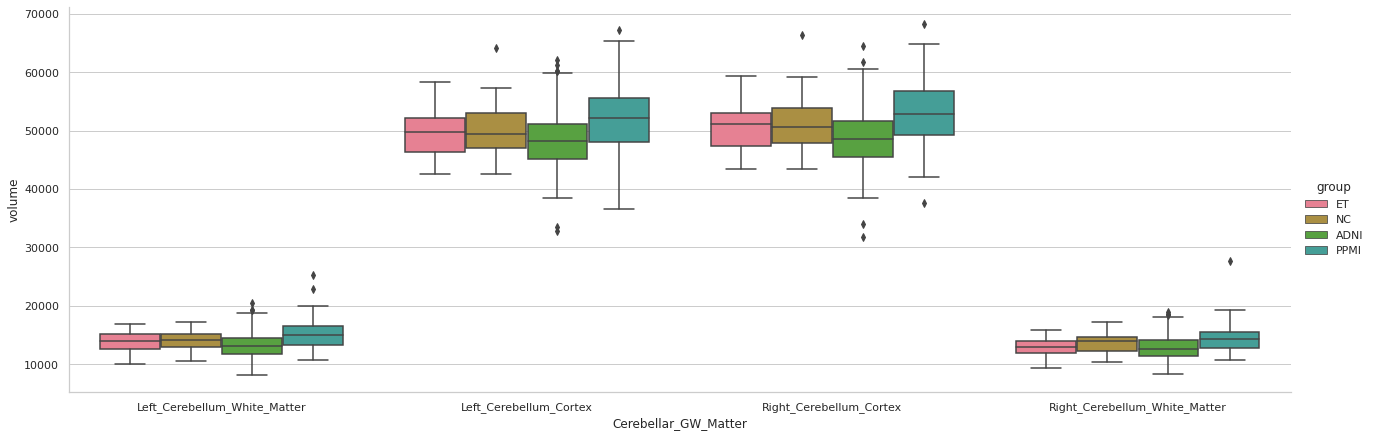

In [11]:
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=curr_df.copy()
vis_suit_df['participant_id']=vis_suit_df.index
vis_label_cerebellar=['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter'];
vis_label_tiv = ['eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent']

palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_l_labels, 
                      var_name ='Left_Cerebellum_Lobule', value_name ='volume')
    g = sns.catplot(y='volume', x='Left_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df)
    plot_v_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_v_labels, 
                      var_name ='Mid_Cerebellum_Lobule', value_name ='volume')
    g1 = sns.catplot(y='volume', x='Mid_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_v_df)
    plot_r_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_r_labels, 
                      var_name ='Right_Cerebellum_Lobule', value_name ='volume')
    g2 = sns.catplot(y='volume', x='Right_Cerebellum_Lobule', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_r_df)
    plot_tiv_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = vis_label_tiv,
                           var_name ='TIV', value_name ='volume')
    g3 = sns.catplot(y='volume', x='TIV', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_tiv_df)
    plot_cere_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = vis_label_cerebellar,
                           var_name ='Cerebellar_GW_Matter', value_name ='volume')
    g4 = sns.catplot(y='volume', x='Cerebellar_GW_Matter', hue='group', kind='box',aspect=3, height=6, palette=palette,
                     data=plot_cere_df)

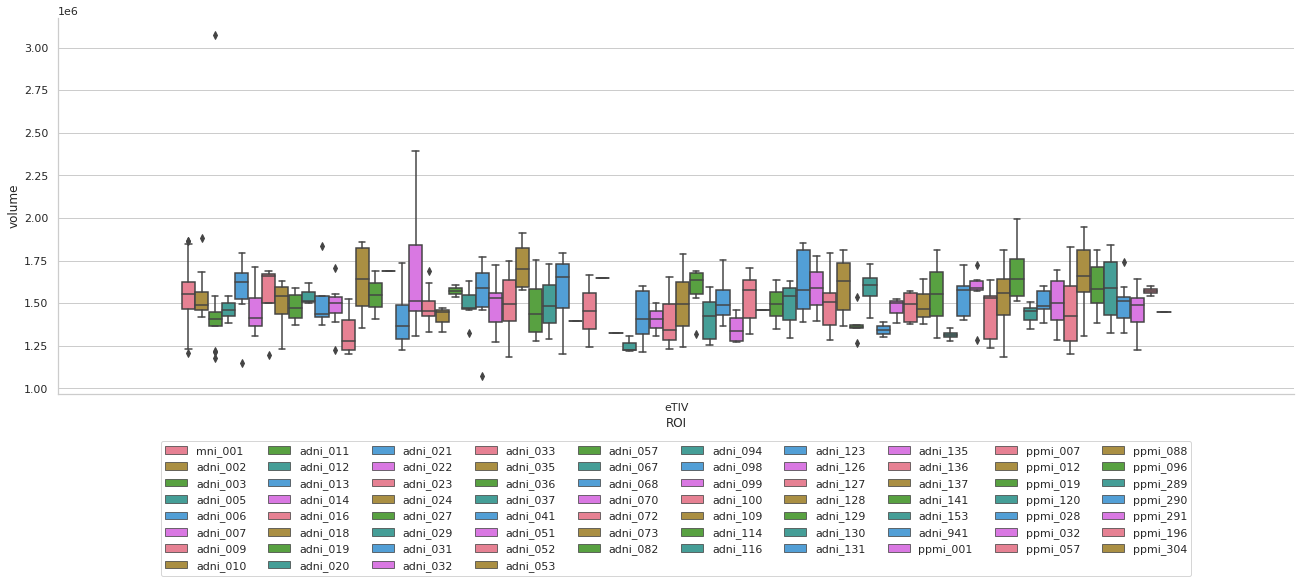

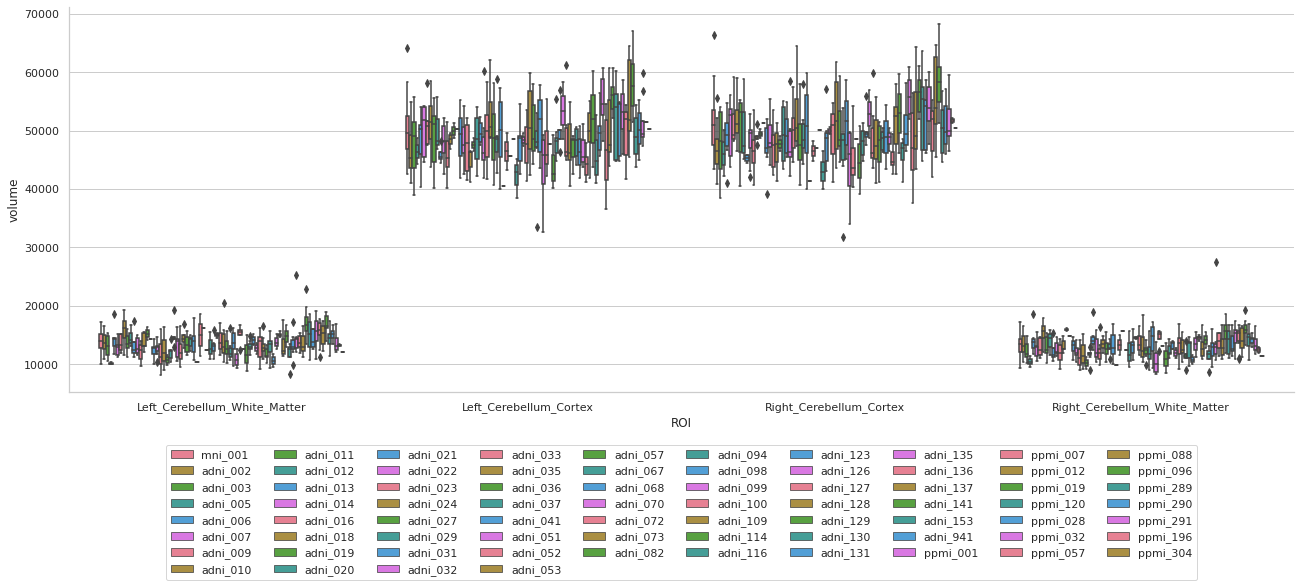

In [12]:
# site effect
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=curr_df.copy()
vis_suit_df['participant_id']=vis_suit_df.index
# ,'SupraTentorialVol', 'SupraTentorialVolNotVent'
vis_label1 = ['eTIV'];
vis_label2=['Left_Cerebellum_White_Matter','Left_Cerebellum_Cortex','Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter']
palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','site'], value_vars = vis_label1, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='site', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df, legend=0 )
    l1 = plt.legend(bbox_to_anchor=(0.5,-0.5), loc="lower center", ncol=10)
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','site'], value_vars = vis_label2, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='site', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df, legend=0)
    l2 = plt.legend(bbox_to_anchor=(0.5,-0.5), loc="lower center", ncol=10)
    

'The cerebellum anatomy'

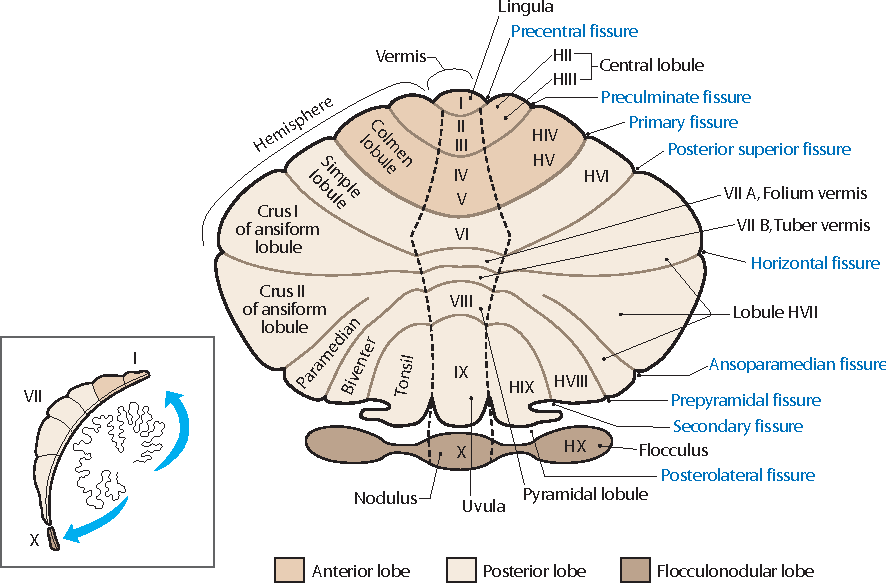

In [13]:
from IPython.display import Image
display("The cerebellum anatomy")
Image("https://d3i71xaburhd42.cloudfront.net/4f1f2faa8782bf9f98d6bf2bf0393b03432f5b56/2-Figure1-1.png")

'The MDTB functional Atlas.'

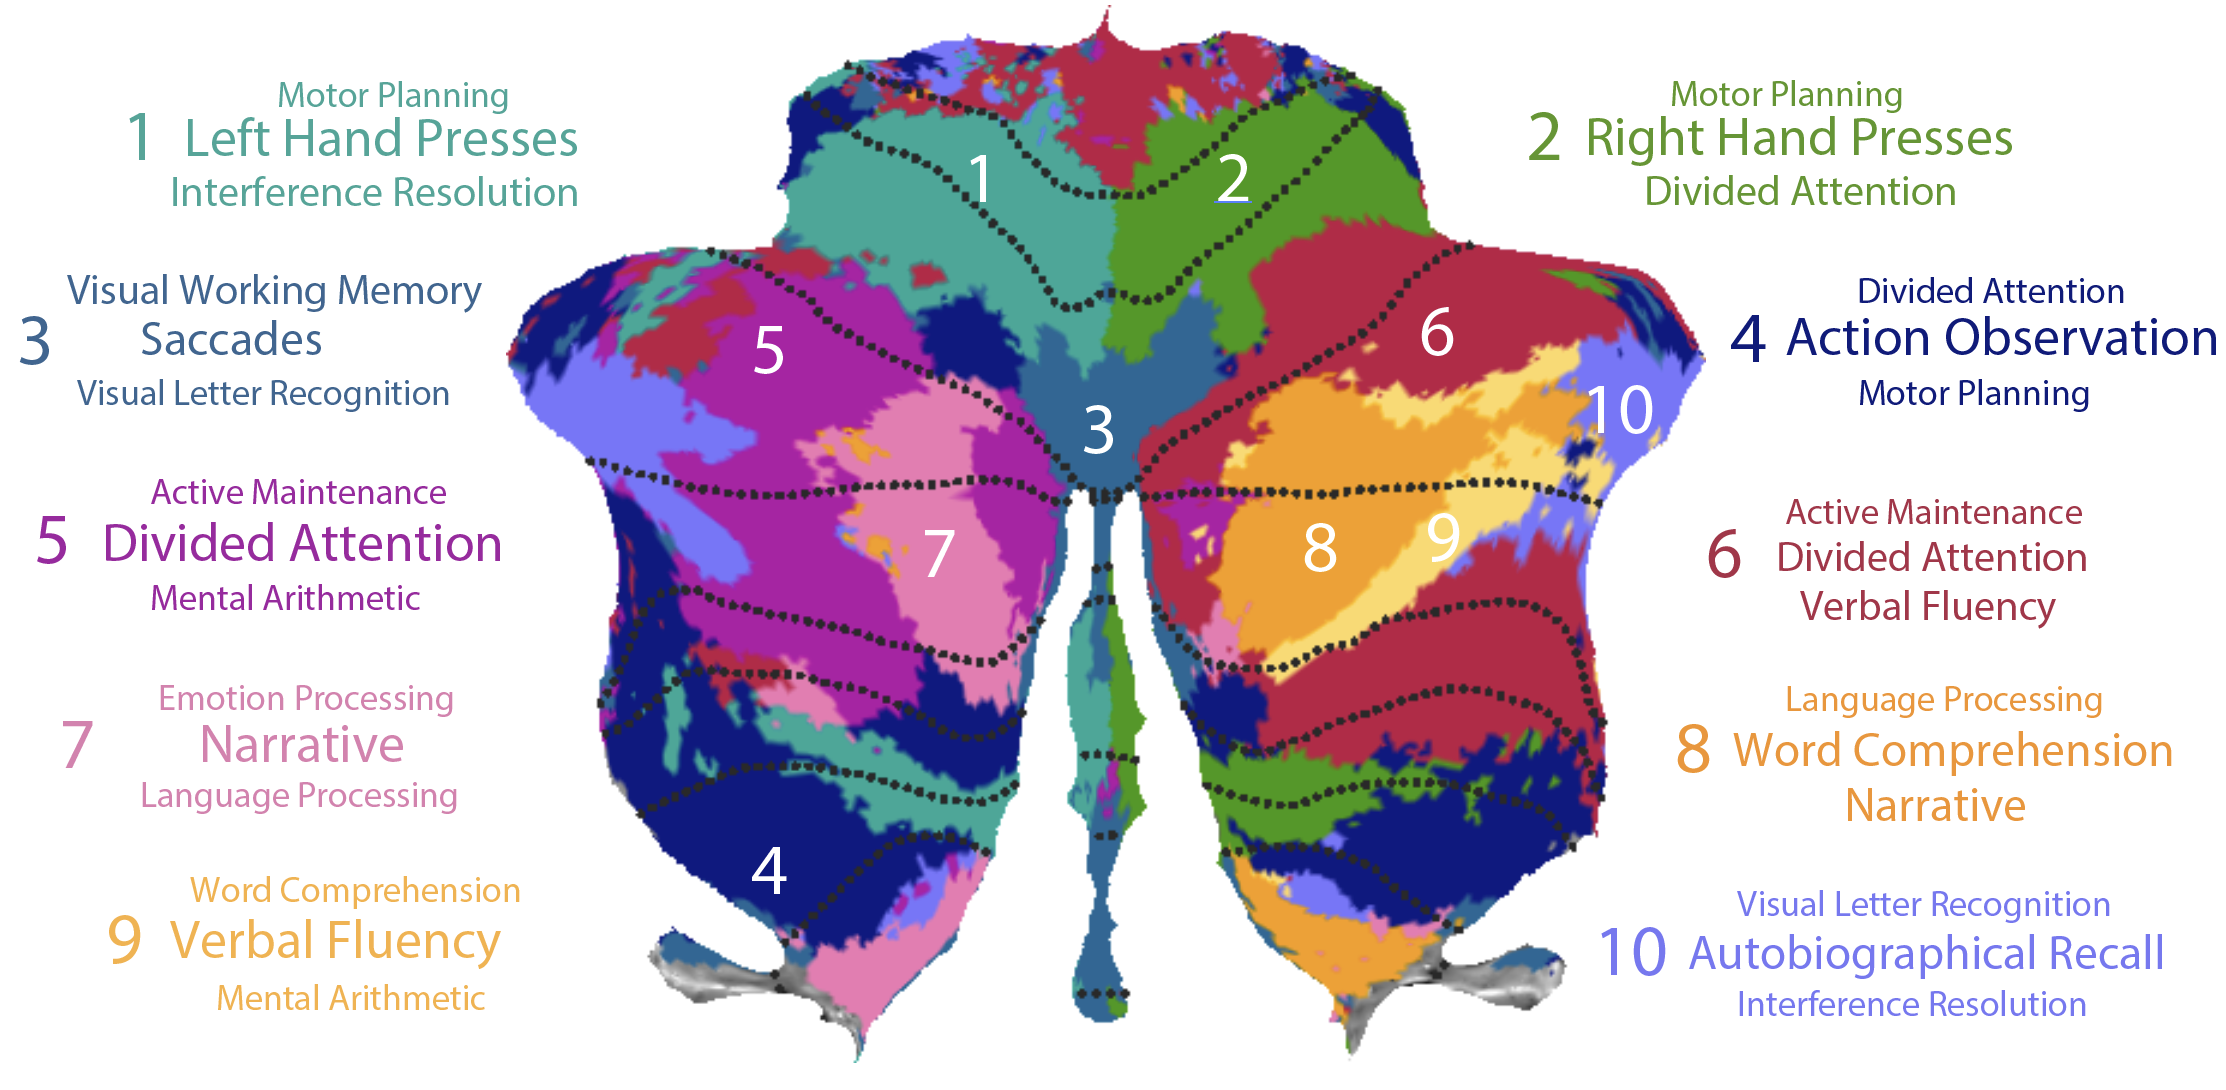

In [14]:
display("The MDTB functional Atlas.")
Image("http://www.diedrichsenlab.org/imaging/Pics/MDTB_parcellation.png")

In [63]:
info_list=['age','sex','group','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];
tar_list = cerebellum_list+lobular_list;

df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])

In [67]:
df_all.columns

Index(['age', 'sex', 'group', 'site', 'eTIV', 'SupraTentorialVol',
       'SupraTentorialVolNotVent', 'Left_Cerebellum_White_Matter',
       'Left_Cerebellum_Cortex', 'Right_Cerebellum_White_Matter',
       'Right_Cerebellum_Cortex', 'Left_I_IV', 'Left_V', 'Left_VI',
       'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb',
       'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed',
       'Left_Fastigial', 'Right_I_IV', 'Right_V', 'Right_VI', 'Right_CrusI',
       'Right_CrusII', 'Right_VIIb', 'Right_VIIIa', 'Right_VIIIb', 'Right_IX',
       'Right_X', 'Right_Dentate', 'Right_Interposed', 'Right_Fastigial',
       'Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb',
       'Vermis_VIIIa', 'Vermis_VIIIb', 'Vermis_IX', 'Vermis_X', 'MDTB_1',
       'MDTB_2', 'MDTB_3', 'MDTB_4', 'MDTB_5', 'MDTB_6', 'MDTB_7', 'MDTB_8',
       'MDTB_9', 'MDTB_10', 'Cerebellum_White_Matter', 'Cerebellum_Cortex',
       'cerebellumVol', 'InfraTentorialVol', 'male', 'is_mni', 'is_

In [20]:
# site effeccts
t_r = 2.4
slice_time_ref = 0.5
from nilearn.datasets import fetch_localizer_first_level
data = fetch_localizer_first_level()
fmri_img = data.epi_img
events_file = data.events
import pandas as pd
events = pd.read_table(events_file)

/usr/local/miniconda/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "



Dataset created in /home/neuro/nilearn_data/localizer_first_level



Downloaded 33734656 of 34532740 bytes (97.7%,    0.3s remaining) ...done. (14 seconds, 0 min)
Extracting data from /home/neuro/nilearn_data/localizer_first_level/62d16779cfae29f3623d6a194141d263/download..... done.


In [21]:
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage()
from nilearn import surface
texture = surface.vol_to_surf(fmri_img, fsaverage.pial_right)
import numpy as np
n_scans = texture.shape[1]
frame_times = t_r * (np.arange(n_scans) + .5)

from nilearn.glm.first_level import make_first_level_design_matrix
design_matrix = make_first_level_design_matrix(frame_times,
                                               events=events,
                                               hrf_model='glover + derivative'
                                               )
from nilearn.glm.first_level import run_glm
labels, estimates = run_glm(texture.T, design_matrix.values)

In [51]:
print(texture.shape)
print(design_matrix.shape)
estimates

(10242, 128)
(128, 27)


AttributeError: 'dict' object has no attribute 'shape'

In [22]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])


In [55]:
design_matrix

,audio_computation,audio_computation_derivative,audio_left_hand_button_press,audio_left_hand_button_press_derivative,audio_right_hand_button_press,audio_right_hand_button_press_derivative,horizontal_checkerboard,horizontal_checkerboard_derivative,sentence_listening,sentence_listening_derivative,...,visual_left_hand_button_press_derivative,visual_right_hand_button_press,visual_right_hand_button_press_derivative,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,constant
1.2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.124991,0.124962,0.124915,0.124849,0.124765,0.124661,1.0
3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.124915,0.124661,0.124238,0.123647,0.122888,0.121963,1.0
6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.124765,0.124060,0.122888,0.121254,0.119163,0.116624,1.0
8.4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.124539,0.123160,0.120872,0.117693,0.113646,0.108761,1.0
10.8,0.0,0.0,0.0,0.0,0.0,0.0,0.011871,0.025550,0.000000,0.000000,...,0.0,0.000000,0.000000,0.124238,0.121963,0.118201,0.112999,0.106419,0.098543,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296.4,0.0,0.0,0.0,0.0,0.0,0.0,-0.000720,0.000400,0.038993,0.042942,...,0.0,0.229332,0.042313,-0.124238,0.121963,-0.118201,0.112999,-0.106419,0.098543,1.0
298.8,0.0,0.0,0.0,0.0,0.0,0.0,-0.000183,0.000109,0.204990,0.064442,...,0.0,0.194193,-0.055436,-0.124539,0.123160,-0.120872,0.117693,-0.113646,0.108761,1.0
301.2,0.0,0.0,0.0,0.0,0.0,0.0,-0.000039,0.000025,0.340362,0.026469,...,0.0,0.051888,-0.052497,-0.124765,0.124060,-0.122888,0.121254,-0.119163,0.116624,1.0
303.6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.263030,-0.077829,...,0.0,-0.030711,-0.017723,-0.124915,0.124661,-0.124238,0.123647,-0.122888,0.121963,1.0


In [23]:
basic_contrasts['audio'] = (
    basic_contrasts['audio_left_hand_button_press']
    + basic_contrasts['audio_right_hand_button_press']
    + basic_contrasts['audio_computation']
    + basic_contrasts['sentence_listening'])

# one contrast adding all conditions involving instructions reading
basic_contrasts['visual'] = (
    basic_contrasts['visual_left_hand_button_press']
    + basic_contrasts['visual_right_hand_button_press']
    + basic_contrasts['visual_computation']
    + basic_contrasts['sentence_reading'])

# one contrast adding all conditions involving computation
basic_contrasts['computation'] = (basic_contrasts['visual_computation']
                                  + basic_contrasts['audio_computation'])

# one contrast adding all conditions involving sentences
basic_contrasts['sentences'] = (basic_contrasts['sentence_listening']
                                + basic_contrasts['sentence_reading'])

In [24]:
contrasts = {
    'left - right button press': (
        basic_contrasts['audio_left_hand_button_press']
        - basic_contrasts['audio_right_hand_button_press']
        + basic_contrasts['visual_left_hand_button_press']
        - basic_contrasts['visual_right_hand_button_press']
    ),
    'audio - visual': basic_contrasts['audio'] - basic_contrasts['visual'],
    'computation - sentences': (basic_contrasts['computation'] -
                                basic_contrasts['sentences']
    )
}

  Contrast  1 out of 3: left - right button press, right hemisphere
  Contrast  2 out of 3: audio - visual, right hemisphere
  Contrast  3 out of 3: computation - sentences, right hemisphere


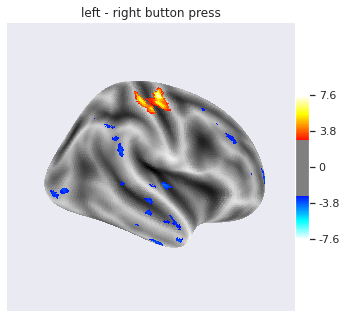

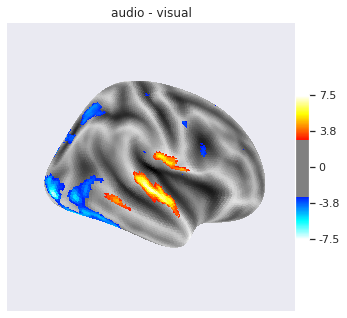

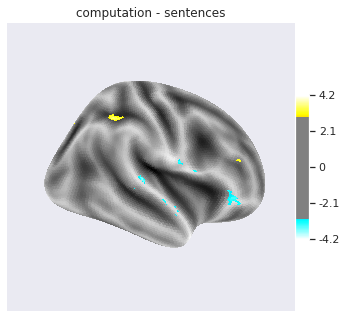

In [25]:
from nilearn.glm.contrasts import compute_contrast
from nilearn import plotting

for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, right hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrast-related statistics
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    # we present the Z-transform of the t map
    z_score = contrast.z_score()
    # we plot it on the surface, on the inflated fsaverage mesh,
    # together with a suitable background to give an impression
    # of the cortex folding.
    plotting.plot_surf_stat_map(
        fsaverage.infl_right, z_score, hemi='right',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_right)

  Contrast  1 out of 3: left - right button press, left hemisphere
  Contrast  2 out of 3: audio - visual, left hemisphere
  Contrast  3 out of 3: computation - sentences, left hemisphere


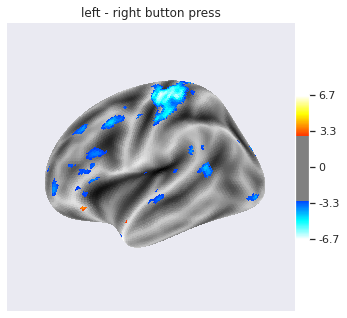

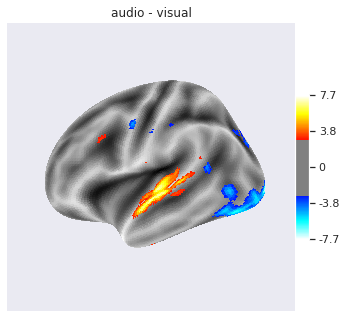

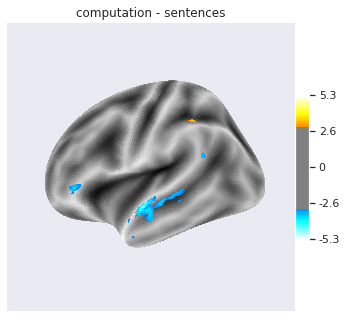

In [26]:
texture = surface.vol_to_surf(fmri_img, fsaverage.pial_left)
labels, estimates = run_glm(texture.T, design_matrix.values)
for index, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    print('  Contrast % i out of %i: %s, left hemisphere' %
          (index + 1, len(contrasts), contrast_id))
    # compute contrasts
    contrast = compute_contrast(labels, estimates, contrast_val,
                                contrast_type='t')
    z_score = contrast.z_score()
    # plot the result
    plotting.plot_surf_stat_map(
        fsaverage.infl_left, z_score, hemi='left',
        title=contrast_id, colorbar=True,
        threshold=3., bg_map=fsaverage.sulc_left)

plotting.show()